Whew! That was a lot of preprocessing and EDA in our previous [notebook](https://colab.research.google.com/drive/1lZhdWA0IxwM9bQPokf7yynX8iRltJ0Ry?authuser=2#scrollTo=lW6tBXyvYx6I)

<img src = https://c.tenor.com/Rlh2p5uef18AAAAM/relief-phew.gif width = 350/>

Our next step is Data Modeling. In this section we will start with our basic sklearn modules and see their performance on the our Dataset. After completing that, we use the AIF360 toolkit to find the bias in our dataset and experiment with various pre processing, in processing and postprocessing methods to mitigate the bias in the data.

# 1\. **Modeling in Scikit Learn**

**Installing required packages**

In [1]:
!pip install aif360
!pip install libraries
!pip install fairlearn

# Setting table to include filter parameters
from google.colab import data_table
data_table.enable_dataframe_formatter()
%load_ext google.colab.data_table

     |████████████████████████████████| 175 kB 5.0 MB/s 
     |████████████████████████████████| 564 kB 32.8 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.59.0-py3-none-any.whl size=31313 sha256=342c7eda94abad485ae7edfb4953501a98b11a327952ba54961f2c66c9388ea9
  Stored in directory: /root/.cache/pip/wheels/8d/6e/d2/af9dae73f8fef0c64c18b0a02a69fbd4c65b854912fa87a390
Successfully built memory-profiler
ERROR: Could not find a version that satisfies the requirement libraries (from versions: none)
ERROR: No matching distribution found for libraries
     |████████████████████████████████| 177 kB 5.1 MB/s 


**Importing required packages**

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from copy import deepcopy as dc
from numpy import mean
from numpy import std
from time import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns
import plotly.offline as py
import plotly.io as pio
import plotly.graph_objs as go
py.init_notebook_mode()

%matplotlib inline

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from IPython.core.display import display, HTML


Output hidden; open in https://colab.research.google.com to view.

**Mounting the drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/Shareddrives/CIS545_Project/'

Mounted at /content/drive


## 1.1. **Encoding Data**

<img src="https://memegenerator.net/img/instances/57220345/what-if-i-told-you-that-youre-encoding-everything-that-i-am-saying.jpg" width="400" />

**Import the csv file we saved after EDA**

In [4]:
all_encoded_data = pd.read_csv(root_path + 'input/encoded_impute_data.csv',sep='\t', encoding='utf-8')
all_encoded_data.drop(columns=["Unnamed: 0"], inplace=True)
# all_encoded_data.drop(columns=["Situation"], inplace=True)
# all_encoded_data.drop(columns=["OffSex"], inplace=True)

# Fill NA
all_encoded_data['VicAge'] = all_encoded_data['VicAge'].fillna(all_encoded_data['VicAge'].median())
all_encoded_data['OffAge'] = all_encoded_data['OffAge'].fillna(all_encoded_data['OffAge'].median())
all_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827217 entries, 0 to 827216
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   State         827217 non-null  object 
 1   Source        827217 non-null  object 
 2   Solved        827217 non-null  object 
 3   Year          827217 non-null  int64  
 4   Month         827217 non-null  object 
 5   Incident      827217 non-null  int64  
 6   ActionType    827217 non-null  object 
 7   Homicide      827217 non-null  object 
 8   Situation     827217 non-null  object 
 9   VicAge        827217 non-null  float64
 10  VicSex        827217 non-null  object 
 11  VicRace       827217 non-null  object 
 12  VicEthnic     827217 non-null  object 
 13  OffAge        827217 non-null  float64
 14  OffSex        827217 non-null  object 
 15  OffRace       827217 non-null  object 
 16  OffEthnic     827217 non-null  object 
 17  Weapon        827217 non-null  object 
 18  Rela

In [5]:
all_cols = all_encoded_data.columns.values
all_cols

array(['State', 'Source', 'Solved', 'Year', 'Month', 'Incident',
       'ActionType', 'Homicide', 'Situation', 'VicAge', 'VicSex',
       'VicRace', 'VicEthnic', 'OffAge', 'OffSex', 'OffRace', 'OffEthnic',
       'Weapon', 'Relationship', 'Circumstance', 'VicCount', 'OffCount'],
      dtype=object)

In [6]:
# Find out all the categorical and the numerical columns
categorical_features, numeric_features = [], []
numeric_types = ["int64", "float64"]

for col in all_cols:
    if all_encoded_data[col].dtypes in numeric_types:
        numeric_features.append(col)
    else:
        categorical_features.append(col)

print(f"We have {len(categorical_features)} categorical columns and {len(numeric_features)} numerical columns")

We have 16 categorical columns and 6 numerical columns


In [7]:
categorical_indices = [np.where(all_cols == col)[0][0] for col in categorical_features]
categorical_names, encoders = {}, {}

# Encode all the categorical columns using label encoder columns
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(all_encoded_data[feature])
    all_encoded_data[feature] = le.transform(all_encoded_data[feature])
    categorical_names[feature] = le.classes_
    encoders[feature] = le

# Scale all the nueric columns
for feature in numeric_features:
    val = all_encoded_data[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    all_encoded_data[feature] = mms.transform(val)
    encoders[feature] = mms

all_encoded_data = all_encoded_data.astype(float)

In [8]:
all_encoded_data.head()

,State,Source,Solved,Year,Month,Incident,ActionType,Homicide,Situation,VicAge,VicSex,VicRace,VicEthnic,OffAge,OffSex,OffRace,OffEthnic,Weapon,Relationship,Circumstance,VicCount,OffCount
0,0.0,0.0,0.0,0.000000,11.0,0.001001,1.0,1.0,5.0,0.303030,1.0,2.0,2.0,0.236559,2.0,4.0,2.0,10.0,20.0,22.0,0.0,0.000
1,0.0,0.0,1.0,0.022727,4.0,0.001001,1.0,1.0,4.0,0.656566,0.0,2.0,2.0,0.602151,1.0,2.0,2.0,10.0,0.0,5.0,0.0,0.000
2,0.0,0.0,1.0,0.022727,7.0,0.001001,1.0,1.0,3.0,0.484848,1.0,5.0,2.0,0.494624,1.0,5.0,2.0,6.0,0.0,24.0,0.0,0.025
3,0.0,0.0,1.0,0.022727,7.0,0.001001,1.0,1.0,4.0,0.272727,1.0,2.0,2.0,0.172043,0.0,2.0,2.0,15.0,14.0,24.0,0.0,0.000
4,0.0,0.0,1.0,0.022727,1.0,0.001001,1.0,1.0,4.0,0.171717,0.0,2.0,2.0,0.161290,1.0,2.0,2.0,7.0,0.0,10.0,0.0,0.000


**We finally have all the data in numbers, which will be our base going forward.**

**We will also store the required values in a pickle file which will be used in our next notebook**

In [9]:
import pickle

feature_data = {"categorical_names": categorical_names, "encoders": encoders, "categorical_indices": categorical_indices,
                     "categorical_features": categorical_features, "numeric_features": numeric_features}
with open(root_path + 'input/feature_data_offsex.pickle', 'wb') as handle:
    pickle.dump(feature_data, handle, protocol = pickle.HIGHEST_PROTOCOL)

with open(root_path + 'input/all_encoded_data_offsex.pickle', 'wb') as handle:
    pickle.dump(all_encoded_data, handle, protocol = pickle.HIGHEST_PROTOCOL)

## 1.2. **PCA**

In [10]:
pca_data = all_encoded_data.copy()

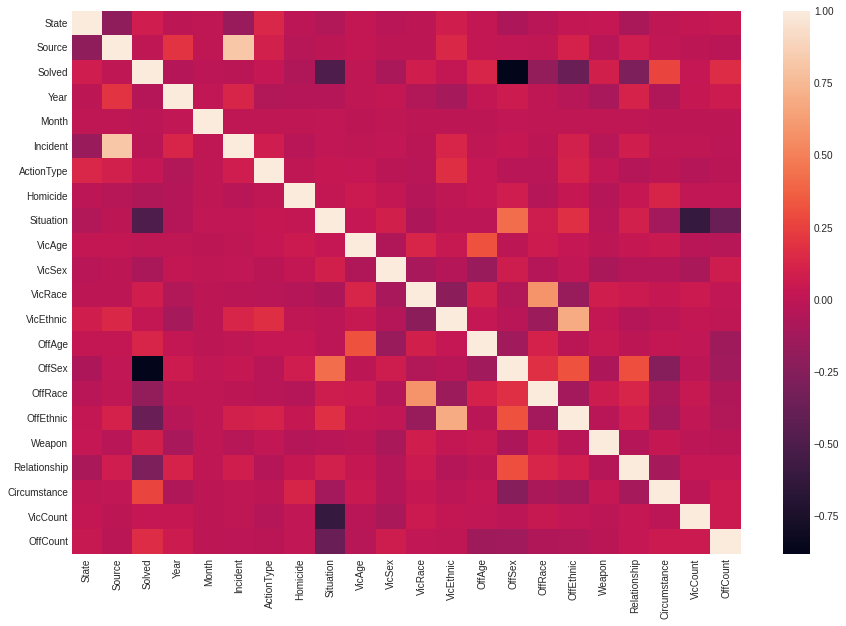

In [11]:
# Check the correlation heatmap
correlations = pca_data.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(correlations)

**Insights:** From a prelimenary look at the data we can see that there is not much correlation between the columns. A couple of columns such as **VicCount** and **Situation** are slightly correlated which we will be fixed using PCA.

In [12]:
features_list = pca_data.columns.values.tolist()
features_list.remove("OffSex")
features, labels = pca_data[features_list], pca_data[["OffSex"]]

In [13]:
# Mark the labels
label_dict = {0:"Female", 1:"Male", 2:"Unknown"}

In [14]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_rem, Y_train, Y_rem = train_test_split(features, labels, test_size=0.3, random_state=0, shuffle = True)
test_size = 0.5
X_dev, X_test, Y_dev, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=0, shuffle = True)

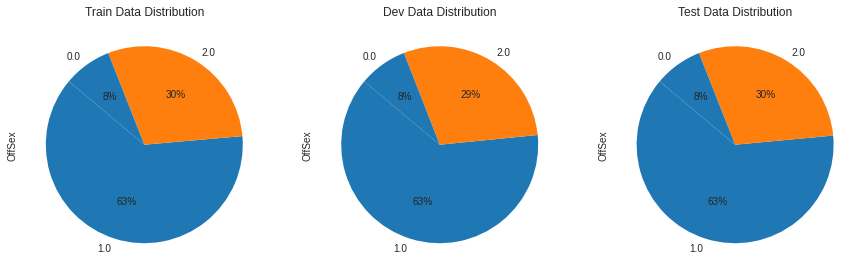

In [15]:
# Ensure distribution of positive and negative labels is not skewed in the splitted data
fig, ax = plt.subplots(figsize=(20,10), nrows=1, ncols=3)

Y_train['OffSex'].value_counts().plot.pie(ax=ax[0], autopct='%1.0f%%', figsize=(15,15),  colors = sns.color_palette()[:2], startangle=140, title = "Train Data Distribution")
Y_dev['OffSex'].value_counts().plot.pie(ax=ax[1], autopct='%1.0f%%', figsize=(15,15),  colors = sns.color_palette()[:2], startangle=140, title = "Dev Data Distribution")
Y_test['OffSex'].value_counts().plot.pie(ax=ax[2], autopct='%1.0f%%', figsize=(15,15),  colors = sns.color_palette()[:2], startangle=140, title = "Test Data Distribution")


<img src = "https://i.kym-cdn.com/entries/icons/original/000/027/257/perfectly-balanced-as-all-things-should-be.jpg" width = 400/>

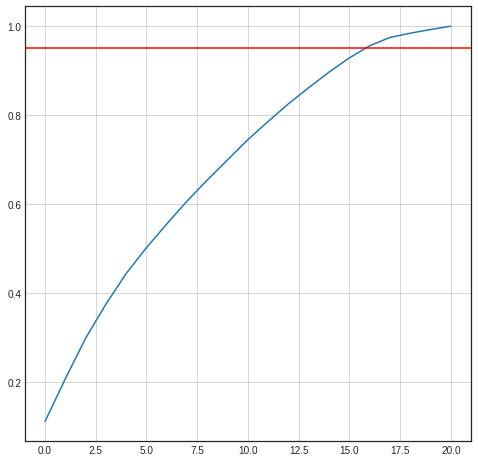

In [16]:
# Let's do PCA 
scaler = StandardScaler()

# find num components to use
pca = PCA()
x_train2 = pca.fit_transform(scaler.fit_transform(X_train))

evr = pca.explained_variance_ratio_
evr_sum = np.cumsum(evr)
plt.figure(figsize = (8,8))
plt.plot(evr_sum)
plt.grid()

# Draw a standard horizontal line at 95% for comparison
plt.axhline(y=0.95, color='r', linestyle='-')

**Insights:** We see 95% of output based on 16 features, so we will drop all other columns

In [17]:
pca_final = PCA(n_components=16)
x_train = pca_final.fit_transform(X_train)
x_dev = pca_final.transform(X_dev)
x_test = pca_final.transform(X_test)

y_train, y_dev, y_test = Y_train["OffSex"].values.ravel(), Y_dev["OffSex"].values.ravel(), Y_test["OffSex"].values.ravel()

## 1.3. **Training, Tuning and Evaluation**

<img src = "https://i.redd.it/5cjdqxcg07k11.png" width = 300/>

In [18]:
# Let's define a K-Fold  object which we will use to tune our model
cv = RepeatedStratifiedKFold(n_repeats=3, random_state=42)

In [19]:
# First we will go with simplest of ML models - The Naive Bayes model.
model_nb = GaussianNB()
scores_bayes = cross_val_score(model_nb, x_train, y_train, scoring='accuracy', cv = cv, n_jobs = -1, error_score = 'raise')
print(f"Average Accuracy Scores over {int(len(scores_bayes))} calculations: {round(mean(scores_bayes)*100,3)}%")

Average Accuracy Scores over 15 calculations: 90.708%


In [20]:
# Run it on validation set and see the results
model_nb.fit(x_train, y_train)
y_pred_bayes_dev = model_nb.predict(x_dev)
print(confusion_matrix(y_dev, y_pred_bayes_dev))
print("\n", classification_report(y_dev, y_pred_bayes_dev))

[[  313  9545    28]
 [  704 76456   624]
 [    0   674 35739]]

               precision    recall  f1-score   support

         0.0       0.31      0.03      0.06      9886
         1.0       0.88      0.98      0.93     77784
         2.0       0.98      0.98      0.98     36413

    accuracy                           0.91    124083
   macro avg       0.72      0.67      0.66    124083
weighted avg       0.87      0.91      0.88    124083



**Insights:** The Naive Bayes model wasn't too shabby with an Accuracy of 90.7%. Next, we will also try out Logistic Regression.

In [21]:
model_lr = LogisticRegression()
scores_lr = cross_val_score(model_lr, x_train, y_train, scoring='accuracy', cv = cv, n_jobs = -1, error_score = 'raise')
print(f"Average Accuracy Scores over {int(len(scores_lr))} calculations: {round(mean(scores_lr)*100,3)}%")

Average Accuracy Scores over 15 calculations: 91.994%


In [22]:
model_lr.fit(x_train, y_train)
y_pred_lr_dev = model_lr.predict(x_dev)
print(confusion_matrix(y_dev, y_pred_lr_dev))
print("\n", classification_report(y_dev, y_pred_lr_dev))

[[    0  9886     0]
 [    0 77753    31]
 [    0    91 36322]]

               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      9886
         1.0       0.89      1.00      0.94     77784
         2.0       1.00      1.00      1.00     36413

    accuracy                           0.92    124083
   macro avg       0.63      0.67      0.65    124083
weighted avg       0.85      0.92      0.88    124083



**Insights:** We notice slight improvement of the scores with an accuracy of 91.9%. We also need to note that LogisticRegression by default adds the L2 penalty, so our model is already regularized.

### 1.3.1. **Stacking - Naive Bayes and Logistic Regression**

Following code (Stacking and Boosting) take a lot of time to run. Please give it sufficient time in case the cells are re-run

In [23]:
# # Let's use a stacking classifier by combining the two 
# level = [('lr', LogisticRegression()), ('bayes', GaussianNB())]
# level_meta = LogisticRegression()
# model_stack = StackingClassifier(estimators = level, final_estimator = level_meta)

# scores_stack = cross_val_score(model_stack, x_train, y_train, scoring='accuracy', n_jobs = -1, error_score='raise')
# print(f"Average Scores over {int(len(scores_stack))} calculations: {round(mean(scores_stack)*100,3)}%")

In [24]:
# model_stack.fit(x_train, y_train)
# y_pred_stack_dev = model_stack.predict(x_dev)
# print(confusion_matrix(y_dev, y_pred_stack_dev))
# print("\n", classification_report(y_dev, y_pred_stack_dev))

### 1.3.2. **Boosting - AdaBoost and GradientBoosting**

We tried Boosting algorithm with out Dataset but unfortunately it is taking a lot of time to process. Hence, we are commenting out the below code. It can be uncommented and run anytime given enough time.

In [25]:
# from sklearn.ensemble import AdaBoostClassifier
# model_ada = AdaBoostClassifier()
# scores_ada = cross_val_score(model_ada, x_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1, error_score = 'raise')
# print(f"Average Scores over {int(len(scores_ada))} calculations: {round(mean(scores_ada)*100,3)}%")

In [26]:
# model_ada.fit(x_train, y_train)
# y_pred_ada_dev = model_ada.predict(x_dev)
# print(confusion_matrix(y_dev, y_pred_ada_dev))
# print("\n", classification_report(y_dev, y_pred_ada_dev))

In [27]:
# from sklearn.ensemble import GradientBoostingClassifier
# model_gb = GradientBoostingClassifier()
# scores_gb = cross_val_score(model_gb, x_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1, error_score = 'raise')
# print(f"Average Scores over {int(len(scores_gb))} calculations: {round(mean(scores_gb)*100,3)}%")

In [28]:
# model_gb.fit(x_train, y_train)
# y_pred_gb_dev = model_gb.predict(x_dev)
# print(confusion_matrix(y_dev, y_pred_gb_dev))
# print("\n", classification_report(y_dev, y_pred_gb_dev))

### 1.3.3. **Bagging - Random Forest Classifier**

In [29]:
model_rf = RandomForestClassifier(random_state = 42)

Hyperparam tuning using RandomizedSearch


In [30]:
# # As the Hyperparamter tuning takes close to 100 minutes to finish, we store the random_forest randomized search result so we can use it at every rerun.
# param_dist = {"n_estimators":[10,100], "max_depth": [3, 10], "max_features": [2, len(X_train.columns)],
#               "min_samples_split":  [2,20], "bootstrap": [True], "criterion": ["gini", "entropy"]}
# n_iter_search = 20
# rscv = RandomizedSearchCV(model_rf, param_distributions = param_dist, n_iter = n_iter_search, cv = 5, verbose = 2)

# t0 = time()
# rscv.fit(x_train, y_train)
# print(f"RandomizedSearchCV took {round((time() - t0),2)} seconds for {n_iter_search} candidates parameter settings with the following results:\n")
# print(rscv.cv_results_)

In [31]:
nan = np.nan
rscv_result = {'params': [{'n_estimators': 10, 'min_samples_split': 2, 'max_features': 21, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}, {'n_estimators': 10, 'min_samples_split': 21, 'max_features': 2, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 10, 'min_samples_split': 20, 'max_features': 2, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}, {'n_estimators': 10, 'min_samples_split': 2, 'max_features': 21, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 10, 'min_samples_split': 20, 'max_features': 2, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 20, 'max_features': 2, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 21, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 20, 'max_features': 21, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 21, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 20, 'max_features': 2, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 2, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 2, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 21, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 20, 'max_features': 21, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}, {'n_estimators': 10, 'min_samples_split': 2, 'max_features': 2, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 20, 'max_features': 2, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 2, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 20, 'max_features': 2, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}, {'n_estimators': 100, 'min_samples_split': 20, 'max_features': 21, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}, {'n_estimators': 10, 'min_samples_split': 20, 'max_features': 21, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': True}], 
               'split0_test_score': [ nan, 0.92200223, 0.91986081, nan, 0.88988093, 0.90806573, nan, nan, nan, 0.92001623, 0.90806573, 0.91995579, nan, nan, 0.88830077, 0.91986944, 0.90661509, 0.90661509, nan, nan], 'split1_test_score': [ nan, 0.92034367, 0.91993783, nan, 0.88848113, 0.90874709, nan, nan, nan, 0.91996373, 0.90874709, 0.91977377, nan, nan, 0.88605474, 0.91969605, 0.90759865, 0.90759865, nan, nan], 'split2_test_score': [ nan, 0.92027459, 0.91991192, nan, 0.88859339, 0.90893705, nan, nan, nan, 0.92008462, 0.90893705, 0.92003281, nan, nan, 0.88698731, 0.91991192, 0.90538814, 0.90538814, nan, nan], 'split3_test_score': [ nan, 0.92108626, 0.92178568, nan, 0.88875745, 0.90848804, nan, nan, nan, 0.91983421, 0.90848804, 0.91999827, nan, nan, 0.88710819, 0.91983421, 0.9050082 , 0.9050082 , nan, nan], 'split4_test_score': [ nan, 0.92017097, 0.92199292, nan, 0.89013902, 0.90786633, nan, nan, nan, 0.92007599, 0.90786633, 0.91965288, nan, nan, 0.88670236, 0.91967015, 0.90676107, 0.90676107, nan, nan], 'mean_test_score': [ nan, 0.92077554, 0.92069783, nan, 0.88917038, 0.90842085, nan, nan, nan, 0.91999496, 0.90842085, 0.9198827 , nan, nan, 0.88703067, 0.91979636, 0.90627423, 0.90627423, nan, nan], 'std_test_score': [ nan, 6.93438441e-04, 9.75349830e-04, nan, 6.95936606e-04, 4.02743110e-04, nan, nan, nan, 9.15120423e-05, 4.02743110e-04, 1.45544962e-04, nan, nan, 7.32291356e-04, 9.60410299e-05, 9.48186168e-04, 9.48186168e-04, nan, nan],
               'rank_test_score': [13,  1,  2, 18, 10,  6, 17, 16, 15,  3,  6,  4, 19, 12, 11,  5,  8,8, 14, 20]}

In [32]:
# Get the params with rank 1 from the result
best_rank_idx = rscv_result["rank_test_score"].index(1)
best_params = rscv_result["params"][best_rank_idx]
best_params

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 2,
 'min_samples_split': 21,
 'n_estimators': 10}

In [33]:
# Redefine RF model with best parameters:
model_rf = RandomForestClassifier(n_estimators = best_params["n_estimators"], bootstrap = best_params["bootstrap"], max_depth = best_params["max_depth"], 
                                  min_samples_split = best_params["min_samples_split"],
                                  criterion = best_params["criterion"], random_state = 42)

In [34]:
model_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=21, n_estimators=10,
                       random_state=42)

In [35]:
y_pred_rf = model_rf.predict(x_dev)
dev_accuracy = model_rf.score(x_dev, y_dev)
print(f"Dev Data accuracy\n{round(dev_accuracy*100,3)}%")

Dev Data accuracy
92.508%


**We see that our Random Forest model shows the best performance. Let's go ahead and use this for our Test Data.**

**We will also plot the ROC curve and se the Area Under Curve for each of the predicted classes.**

In [36]:
# Get metrics
def get_metrics(X, y, y_pred, probs):
    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    f1score = f1_score(y, y_pred)
    predictions = probs[:, 1]
    fpr, tpr, _ = roc_curve(y, predictions)
    auc_score = auc(fpr, tpr)
    return acc, cm, f1score, fpr, tpr, auc_score

# We define a custom ROC curve plotting code for area under curve for each class
def plot_perf(model, X_test, y_test, n_classes = 3, aif_flag = False):
    
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # structures
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], probs[:, i])
        roc_auc[i] = round(auc(fpr[i], tpr[i]),5)

    print(f"Accuracy of the model on Test Data: {round(acc*100,3)}%\n")

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    for i in range(n_classes):
        nlabel = label_dict[i]
        if aif_flag:
            nlabel = "Male" if i == 0 else "Others"
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]}) for class: {i} = {nlabel}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

Accuracy of the model on Test Data: 92.508%



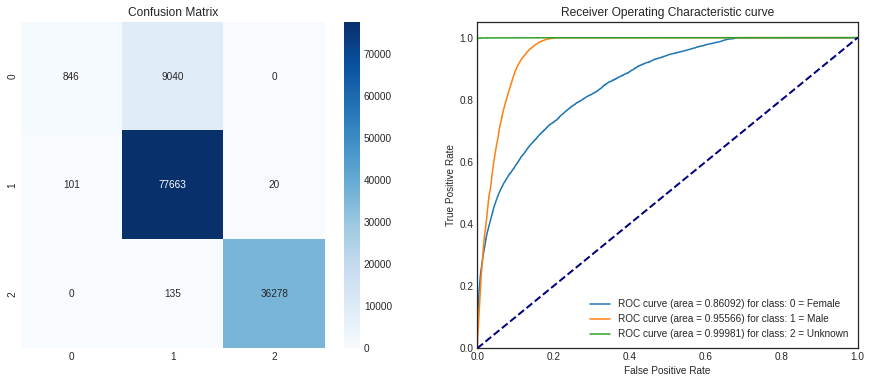

In [37]:
plot_perf(model_rf, x_dev, y_dev, n_classes=3)

**Insigts:** This is great! Our results are in line with our expectations.

We see a decreased performance on the (label = 0) because of the fact that we have only few datapoints for Female offenders. Overall, our model is pretty robust and performs well on new data with an accuracy around 92.5% on Test Data.

We have done the basic modeling pipeline till this point where we try and improve our models to fit our data better and at the end, we made the predictions on the Test Data.

**We now go ahead further and want to introduct the AIF360 toolkit which we will use with our best model - and call it the "Origin" and compare with the internal debiased models that the toolkit provides and compare with Origin.**

# 2\. **Modeling in AI Fairness 360 - AIF360**

AIF360 internally does PCA and data scaling. So, there is less preprocessing here. However, we need to define the "Privileged" classes that might show a biased tendency.
Also an important point to note here, we can only define 1 favourable class here (In our case it will be Male), All other classes (Female + Unknown) will be unfavourable, which gives us a binary classification problem

In [38]:
# Let's define the privileged classes (White and male)
protected_cols = ['VicSex', 'VicRace', 'OffRace']
priv_classes = [np.where(categorical_names['VicSex'] == 'Male')[0], np.where(categorical_names['VicRace'] == 'White')[0], np.where(categorical_names['OffRace'] == 'White')[0]]

# Define the StandardDataset of AIF360
std_data = StandardDataset(all_encoded_data, label_name = "OffSex", favorable_classes = [1],
                           protected_attribute_names = protected_cols, privileged_classes = priv_classes)

In [39]:
def print_metadata(data):
    print(f"\nData Shape:\n{data.features.shape}")
    print(f"\nData Features:\n{data.feature_names}")
    print(f"\nFavourable and Unfavourable Labels:\nMale: {data.favorable_label} , Other: {data.unfavorable_label}")
    print(f"\nProtected Attributes:\n{data.protected_attribute_names}")
print_metadata(std_data)


Data Shape:
(827217, 21)

Data Features:
['State', 'Source', 'Solved', 'Year', 'Month', 'Incident', 'ActionType', 'Homicide', 'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'OffAge', 'OffRace', 'OffEthnic', 'Weapon', 'Relationship', 'Circumstance', 'VicCount', 'OffCount']

Favourable and Unfavourable Labels:
Male: 1.0 , Other: 0.0

Protected Attributes:
['VicSex', 'VicRace', 'OffRace']


## 2.1. **Random Forest on StandardDataset**

In [40]:
def get_X_Y_weights(data, testFlag = False):
    if not testFlag:
        return data.features, data.labels.ravel(), data.instance_weights
    return data.features, data.labels.ravel()

In [41]:
np.random.seed(42)

train_data, test_data = std_data.split([0.7], shuffle=True)
print(f"\nTrain Dataset shape: {train_data.features.shape}")
print(f"\nTest Dataset shape: {test_data.features.shape}")
x_train_aif, y_train_aif, weights = get_X_Y_weights(train_data)
x_test_aif, y_test_aif = get_X_Y_weights(test_data, testFlag = True)


Train Dataset shape: (579051, 21)

Test Dataset shape: (248166, 21)


In [42]:
# Get the best RF model and train and save the models
# rf_clf = RandomForestClassifier()
model_rf_aif = model_rf.fit(x_train_aif, y_train_aif, sample_weight = weights)

Accuracy of the model on Test Data: 92.427%



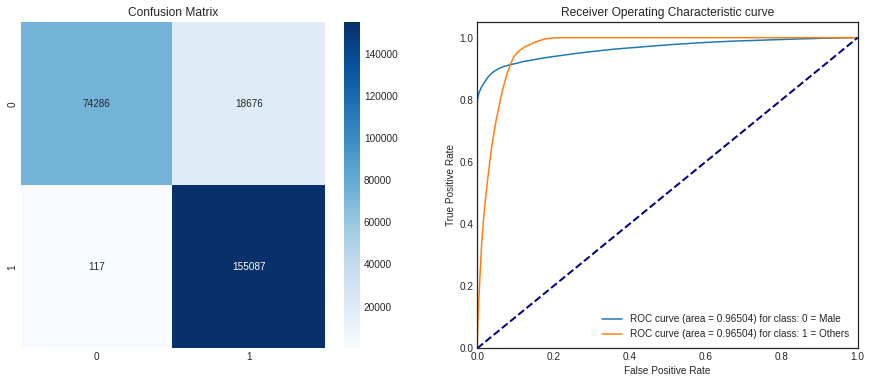

In [43]:
plot_perf(model_rf_aif, x_test_aif, y_test_aif, n_classes = 2, aif_flag = True)

**Insights:** Our RF model performance with AIF360 is inline with the sklearn RF with an accuracy around 92.4%. 


<img src="https://miro.medium.com/max/570/0*y8AuUHSoTGRqX40h.jpeg" width="600" />

## 2.2. **Bias Detection**
We need to check if our model is biased. We can do that using the following metrics provided by [aif360](https://github.com/IBM/AIF360):

*   Disparate Impact
*   Equal Opportunity Difference
*   Statistical Parity Difference
*   Average Absolute Odds Difference
*   Theil Index


<img src="https://miro.medium.com/max/1120/0*nsgXxd0kwN3qT2ks.gif" width="500" />

**What do these terms mean?**

As Data Scientists, when we consider ML models and building ML pipelines, we need to understand what exactly bias, privileged and unprivileged classes are,what do they mean and how do they affect our classification models.

While we define each of the metrics briefly, we also provide detailed documentaiton links for better understanding


### 2.1.1. **Disparate Impact**

[Disparate Impact](https://aif360.readthedocs.io/en/latest/modules/metrics.html\#aif360.metrics.ClassificationMetric.disparate_impact) is the ratio of the probability that the case of a random individual drawn from the unprivilidged class is labelled 1 by the probability that the case of a random individual drawn from the privilidged class is labelled 1. The closer the value is to 1, the fairer the model is.



### 2.2.2. **Equal Opportunity Difference**
[Equal opportunity difference](https://aif360.readthedocs.io/en/latest/modules/metrics.html\#aif360.metrics.ClassificationMetric.equal_opportunity_difference) is the difference between the true positive rate of the privilidged and unprivilidged groups. The closer the value is to 0, the more fair the model is.



### 2.2.3. **Statistical Parity Difference**
[Statistical Parity Difference](https://aif360.readthedocs.io/en/latest/modules/metrics.html\#aif360.metrics.BinaryLabelDatasetMetric.statistical_parity_difference) measures the difference between the probability that the case of a random individual drawn from the privilidged class is labelled 1 and the the probability that the case of a random individual drawn from the unprivilidged class is labelled 1. The closer the value is to 0, the more fair the model is.



### 2.2.4. **Theil Index**
[Theil Index](https://aif360.readthedocs.io/en/latest/modules/metrics.html\#aif360.metrics.ClassificationMetric.theil_index) is a generalized entropy index with $\alpha = 1$. The closer the value is to 0, the fairer the model is.



### 2.2.5. **Average Absolute Odds Difference (AAOD)**
[AAOD](https://aif360.readthedocs.io/en/latest/modules/metrics.html\#aif360.metrics.ClassificationMetric.average_abs_odds_difference) uses false positive rate and true positive rate to calculate the equality of odds and hence the bias. The closer the value is to 0, the fairer the model is.



Some metrics require the original dataset and for others the prediction is needed. `ClassificationMetric` and `BinaryLabelDatasetMetric` are the 2 classes of the aif360 package.

In [44]:
# Few variables we will need
metric_cols = ['model', 'fair_metrics', 'prediction', 'probs']
bias_cols = ['disparate_impact', 'equal_opportunity_difference', 'statistical_parity_difference', 'theil_index', 'average_abs_odds_difference']
fairness_values = [[1, 0, 0, 0, 0]]

# Create a DataFrame to identify different models and fair metrics
metrics_df = pd.DataFrame(columns = metric_cols)

# Append to metrics df
def append_rows(df, model, fair_metrics, prediction, probs, name):
    data = [[model, fair_metrics, prediction, probs]]
    return df.append(pd.DataFrame(data = data, columns = metric_cols, index = [name]))

In [45]:
# Method to return Unbiased metrics
def unbiased_metrics(dataset, pred, same = False):

    dp = pred
    if not same:
        dp = dataset.copy()
        dp.labels = pred

    fair_df = pd.DataFrame(data = fairness_values, index = ['objective'], columns = bias_cols)

    for protected_attr in dp.protected_attribute_names:
        i = dp.protected_attribute_names.index(protected_attr)
        priv_val = dp.privileged_protected_attributes[i][0]
        unpriv_val = dp.unprivileged_protected_attributes[i][0]
        priv_grp = [{protected_attr : priv_val}]
        unpriv_grp = [{protected_attr : unpriv_val}] 

        # Get the 2 AIF360 metrics
        clf_metric = ClassificationMetric(dataset, dp, privileged_groups = priv_grp, unprivileged_groups = unpriv_grp)
        pred_metric = BinaryLabelDatasetMetric(dp, privileged_groups = priv_grp, unprivileged_groups = unpriv_grp)

        # Create a row with all the bias metrics using the above object
        disp_imp = pred_metric.disparate_impact()
        eod = clf_metric.equal_opportunity_difference()
        spd = pred_metric.mean_difference()
        ti, aaod = clf_metric.theil_index(), clf_metric.average_abs_odds_difference()
        bias_vals = [disp_imp, eod, spd, ti, aaod]

        # Add the row to fair df
        fair_df = fair_df.append(pd.DataFrame([bias_vals], columns = bias_cols, index = [protected_attr]))
    fair_df = fair_df.replace([-np.inf, np.inf], 2)
    return fair_df    

# We use the following method to visualize all the model results.
def plot_unbiased_df(fair_df):

    # Define the axis with 5 columns for each fairness metric
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)
    plt.subplots_adjust(
        left = 0.125, right = 0.9,
        top = 0.9, bottom = 0.1,
        wspace = .5, hspace = 1.1
    )
    y_title_margin = 1.2
    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style = "dark")

    fair_cols = fair_df.columns.values
    objective = fair_df.loc['objective']
    size_rect = [0.4, 0.2, 0.2, 0.25, 0.2]
    rect = [0.8, -0.1, -0.1, 0, -0.1]
    bottom = [0, -1, -1, 0, -1]
    top = [2, 1, 1, 1, 1]
    bound = [[0.8,1.2], [-0.1,0.1], [-0.1,0.1], [0,0.25], [-0.1,0.1]]

    length = len(fair_df)

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        x_vals = fair_df.index[1 : length]
        y_vals = fair_df.iloc[1 : length][fair_cols[i]]
        ax = sns.barplot(x = x_vals, y = y_vals)
        
        for j in range(0, length-1):
            a, val = ax.patches[j], fair_df.iloc[j+1][fair_cols[i]]
            margin = -0.2 if val < 0 else 0.1
            ax.text(a.get_x() + a.get_width()/5, a.get_y() + a.get_height() + margin, round(val, 3), fontsize=15, color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5, rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(objective[i], color='black', alpha=0.3)
        plt.title(fair_cols[i])

In [46]:
# Predict using the given model and return the df. Also, plot if the flag is true.
def predict_and_plot(data, model, plot = True, model_aif = False):    
    labels = model.predict(data).labels if model_aif else model.predict(data.features)
    fair_df = unbiased_metrics(data, labels)

    if plot:
        plot_unbiased_df(fair_df)
    
    return fair_df

**Let's see how our RF model (Origin) does with respect to the metrics**


-- Fairness metrics for the model --



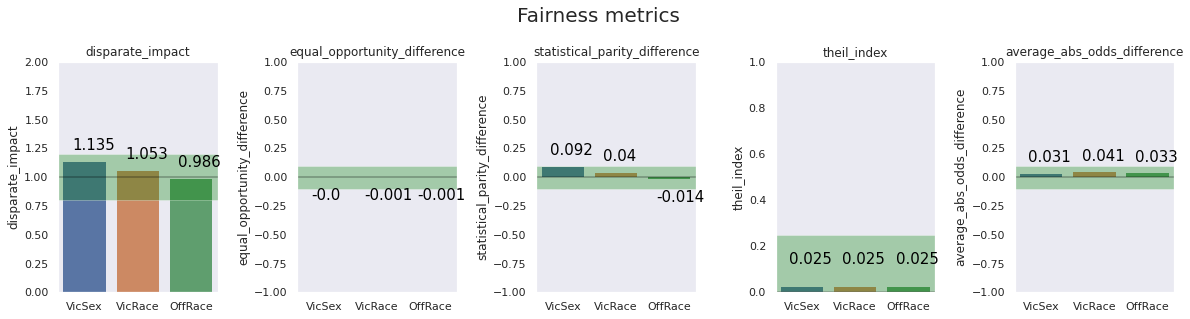

In [47]:
fair_df = predict_and_plot(test_data, model_rf_aif)
print(f'\n-- Fairness metrics for the model --\n')

**Insights:** We see that while all the metrics show that we don't have any significant bias towards classifying the Offender Sex. However, both `statistical_parity_difference` and `disparate_impact` show that **VicSex** might be somewhat biasing our prediction.

## 2.3. **Bias Mitigation**

We present three types of algorithms that AIF360 provides us:
* Pre-processing algorithms : bias mitigation before the model is trained.
* In-processing algorithms : bias mitigation while the model is being trained.
* Post-processing algorithms : bias mitigation after the model is trained.

In a fair ML pipeline, the data is pre processed and a classifier is learnt from this transformed dataset and obtaining predictions from the classifier. The metrics are calculated at each stage and steps to mitigate the bias are taken when the metrics exceed the threshold values.


**Fairness Pipeline**

<img src = https://d3i71xaburhd42.cloudfront.net/ddc0c5f697b84d501bc6ad7e60d396596dfc7ae4/2-Figure1-1.png width = 2000/>

[Reference Paper](https://www.semanticscholar.org/paper/LiFT%3A-A-Scalable-Framework-for-Measuring-Fairness-Vasudevan-Kenthapadi/ddc0c5f697b84d501bc6ad7e60d396596dfc7ae4)







### 2.3.1. **Pre-processing algorithms**
We will be looking at 2 [pre-processing algorithms](https://aif360.readthedocs.io/en/latest/modules/preprocessing.html\#):

*   Learning fair representations
*   Reweighing



In [48]:
# Populate the metrics_df with original values before Bias mitigation
probs = model_rf_aif.predict_proba(x_test_aif)
preds = model_rf_aif.predict(x_test_aif)
metrics_df = append_rows(metrics_df, model_rf_aif, fair_df, preds, probs, "Origin")

In [49]:
# This method is to get the privileged and unprivileged group data along with the data points
def get_groups(data, protected_attribues = None):
    
    priv_grp, unpriv_grp = [], []
    if not protected_attribues:
        protected_attribues = data.protected_attribute_names
    
    for attribute in protected_attribues:
        i = data.protected_attribute_names.index(attribute)
        priv_val = {attribute : data.privileged_protected_attributes[i]}
        unpriv_val = {attribute : data.unprivileged_protected_attributes[i]}
        priv_grp.append(priv_val)
        unpriv_grp.append(unpriv_val)

    return priv_grp, unpriv_grp

In [50]:
# We will use the below method to predict and store the results in our "metrics_df" for both out preprocessing algorithms
def preprocess_aif360(model, train_data, test_data, metrics_df, colname):
    transformed_train_data = model.fit_transform(train_data)
    X, y, weights = get_X_Y_weights(transformed_train_data)

    transformed_test_data = model.transform(test_data)
    fair_df = predict_and_plot(transformed_test_data, model_rf_aif, plot = False)
    probs = model_rf_aif.predict_proba(test_data.features)
    preds = model_rf_aif.predict(test_data.features)

    metrics_df = append_rows(metrics_df, model_rf_aif, fair_df, preds, probs, colname)
    return metrics_df


#### 2.3.1.1. **Learning fair representations**

Learning fair representations (LFR) is a pre-processing technique that finds a latent representation that obfuscates information about the protected attribute but ecodes the data well. The drawback of LFR is that it only works on one protected attribute.

In [51]:
from time import time

# Get priv and unpriv groups for VicRace - this is the one protected attribute we will use in our case
priv_grp_one, unpriv_grp_one = get_groups(train_data, protected_attribues = ['VicRace'])

# Calculate with LFR for VicRace
t0 = time()
LFR_model = LFR(unprivileged_groups = unpriv_grp_one, privileged_groups = priv_grp_one, k = 1)
metrics_df = preprocess_aif360(LFR_model, train_data, test_data, metrics_df, "LFR")
print(f'\nTime taken for LFR = {round((time()-t0), 4)} secs\n')


Time taken for LFR = 67.5262 secs




#### 2.3.1.2. **Reweighing**

Reweighing is a preprocessing technique assigns Weights to the examples in each (group, label) combination differently to ensure fairness before classification.

In [52]:
# Get priv and unpriv groups for all protected attributes
priv_grp, unpriv_grp = get_groups(train_data, protected_attribues = protected_cols)

# Calculate with Reweighing for all
t0 = time()
RW = Reweighing(unprivileged_groups = unpriv_grp, privileged_groups = priv_grp)
metrics_df = preprocess_aif360(RW, train_data, test_data, metrics_df, "Reweighing")
print(f'\nTime taken for Reweighing = {round((time()-t0), 4)} secs\n')


Time taken for Reweighing = 3.4509 secs



### 2.3.2. **In-processing algorithms**

We will be looking at the following [inprocessing algorithm](https://aif360.readthedocs.io/en/latest/modules/inprocessing.html):

* Adversarial Debiasing

In [53]:
def inprocess_aif360(model, train_data, test_data, metrics_df, colname):
    model.fit(train_data)
    fair_df = predict_and_plot(test_data, model, plot = False, model_aif = True)
    preds = model.predict(test_data)
    metrics_df = append_rows(metrics_df, model, fair_df, preds.labels, preds.scores, colname)
    return metrics_df

####  2.3.2.1. **Adversarial Debiasing**
Adversarial debiasing learns a cassifier that simultaneously maximises accuracy and minimises an adversary's ability to determine the protected attribute. However it supports only one privileged group.

In [54]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
session = tf.compat.v1.Session()

t0 = time()
adv_debiased_model = AdversarialDebiasing(privileged_groups = priv_grp_one, unprivileged_groups = unpriv_grp_one, 
                                          scope_name='debiased_classifier', num_epochs=10, sess = session)

try:
    metrics_df = inprocess_aif360(adv_debiased_model, train_data, test_data, metrics_df, "AdvDebiasing")
    print(f'\nTime taken for Adversarial debiasing = {round((time()-t0), 4)} secs\n')
except:
    print("Adversarial Debiasing as already been run, so skipping")


Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 2.156463; batch adversarial loss: 0.220029
epoch 0; iter: 200; batch classifier loss: 1.277987; batch adversarial loss: -0.007505
epoch 0; iter: 400; batch classifier loss: 1.413661; batch adversarial loss: -0.539351
epoch 0; iter: 600; batch classifier loss: 1.878911; batch adversarial loss: -1.021323
epoch 0; iter: 800; batch classifier loss: 2.268323; batch adversarial loss: -1.484116
epoch 0; iter: 1000; batch classifier loss: 2.992241; batch adversarial loss: -2.085872
epoch 0; iter: 1200; batch classifier loss: 3.410980; batch adversarial loss: -2.685221
epoch 0; iter: 1400; batch classifier loss: 3.209379; batch adversarial loss: -2.844197
epoch 0; iter: 1600; batch classifier loss: 2.506767; batch adversarial loss: -3.651272
epoch 0; iter: 1

### 2.3.3. **Post-processing algorithms**
[Post-processing algorithms](https://aif360.readthedocs.io/en/latest/modules/postprocessing.html) require a dataset that has the predicted scores and labels.

In [55]:
test_data_post = test_data.copy(deepcopy=True)

# Prediction with the original RandomForest model
probs_post = np.zeros_like(y_test)
probs_post = model_rf_aif.predict_proba(x_test_aif)[:,1].reshape(-1,1)
test_data_post.scores = probs_post

preds_post = np.zeros_like(y_test_aif)
preds_post = model_rf_aif.predict(x_test_aif).reshape(-1,1)
test_data_post.labels = preds_post

def format_probs(probs_pos):
    probs_pos = np.array(probs_pos)
    probs_neg = np.array(1 - probs_pos)
    return np.concatenate((probs_neg, probs_pos), axis=1)

#### 2.3.3.1. **Calibrated Equality of Odds**
The calibrated classifier score outputs are optimized to find which probabilities the output labels need to be changed for an equalized odds objective.

In [56]:
t0 = time()
CEOP = CalibratedEqOddsPostprocessing(privileged_groups = priv_grp, unprivileged_groups = unpriv_grp, cost_constraint = "fnr", seed = 42)
CEOP = CEOP.fit(test_data, test_data_post)
preds_ceop = CEOP.predict(test_data_post)

fair_df_ceop = unbiased_metrics(test_data, test_data_post, same = True)
metrics_df = append_rows(metrics_df, CEOP, fair_df_ceop, preds_ceop.labels, format_probs(preds_ceop.scores), 'CalibratedEqOdds')
print(f'\nTime taken for Calibrated Equality of Odds = {round((time()-t0), 4)} secs\n')


Time taken for Calibrated Equality of Odds = 4.1412 secs



In [57]:
metrics_df

,model,fair_metrics,prediction,probs
Origin,"(DecisionTreeClassifier(max_depth=10, max_feat...",disparate_impact ... average_abs_...,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[[0.15437360269682507, 0.8456263973031749], [0..."
LFR,"(DecisionTreeClassifier(max_depth=10, max_feat...",disparate_impact ... average_abs_...,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[[0.15437360269682507, 0.8456263973031749], [0..."
Reweighing,"(DecisionTreeClassifier(max_depth=10, max_feat...",disparate_impact ... average_abs_...,"[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[[0.15437360269682507, 0.8456263973031749], [0..."
AdvDebiasing,<aif360.algorithms.inprocessing.adversarial_de...,disparate_impact ... average_abs_...,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.000434190034866333], [7.123078571424912e-0..."
CalibratedEqOdds,<aif360.algorithms.postprocessing.calibrated_e...,disparate_impact ... average_abs_...,"[[1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1....","[[0.1543736026968251, 0.8456263973031749], [1...."


## 2.4. **Bias Visualization**

Great! We have the `metrics_df` populated with all the required information. Now, the final step is to check the results after AIF360 mitigated the biases.

For this, let us first define a method which takes the `metrics_df` and plots the metrics we discussed in the [bias detection](https://colab.research.google.com/drive/1bLTKZP2xyjnMfn2lZh5-_EJnzdsnks6m?authuser=2#scrollTo=uR9VI1mf5mua) section for each model 

In [58]:
def plotly_bias_model(metrics_df):
    
    # Coordinates
    bottom = [0, -1, -1, 0, -1]
    right = [1.2, 0.1, 0.1, 0.25, 0.1]
    left = [0.8, -0.1, -0.1, 0, -0.1]
    all_cols = metrics_df.columns.values

    i = 0
    while i<5:
        curr_col = all_cols[i]
        X_plot = metrics_df[curr_col].values
        y_plot = metrics_df.index


        colors = []
        for boundary in X_plot:
            color = '#e74c3c' if boundary < left[i] or boundary > right[i] else '#2ecc71'
            colors.append(color)
        
        marker = dict(color = colors)
        bar = go.Bar(x = X_plot, y = y_plot, marker = marker, opacity = 0.85, orientation = 'h')

        #Shape
        layout_base = {'type': 'line', 'y0': -1, 'y1': len(y_plot), 'line': {'color': 'rgb(0, 0, 0)', 'width': 2}}
        layout_left = dc(layout_base)
        layout_right = dc(layout_base)
        layout_left["x0"], layout_left["x1"] = left[i], left[i]
        layout_right["x0"], layout_right["x1"] = right[i], right[i]

        x_ax = dict(range = [bottom[i], bottom[i] + 2])
        y_ax = go.layout.YAxis(automargin=True)
        lay = go.Layout(barmode = 'group', title = curr_col, xaxis = x_ax, yaxis = y_ax, shapes = [layout_left, layout_right])
        fig = go.Figure([bar], layout = lay)

        # Save the fig to display later
        save_path = root_path+f'iris{i}.html'
        pio.write_html(fig, file = save_path)
        i+=1

def plotly_all_scores(scores_df):

    print("\n\n")
    sort_cols = ['nb_valid', 'score']
    print(f"\n\nFinal unbiased scores (NaN scores removed) of all the models")
    display(scores_df.sort_values(sort_cols, ascending=[0, 1]))
    scores_df.sort_values(sort_cols, ascending=[1, 0], inplace = True)

    #0:gold, 1:silver, 2:bronze, 3:other
    color_dict = {0:'#FFA400', 1:'#bdc3c7', 2:'#cd7f32', 3:'#3498db'}
    colors = [c for c in reversed([color_dict[i] for i in range(len(scores_df))])]

    X_plot = scores_df["score"].values
    y_plot = scores_df.index

    bar = go.Bar(x = X_plot, y = y_plot, marker = dict(color=colors), opacity = 0.85, orientation = 'h')
    lay = go.Layout(barmode='group', title='Fairest algorithm', yaxis = go.layout.YAxis(automargin=True))

    # Save the fig to use it later
    fig = go.Figure([bar], layout = lay)
    pio.write_html(fig, file=root_path+'biris.html')
    

def get_score_df(fair_df):

    # Optimal values for each metric
    obj = [0, 0, 0, 1, 0]
    right = [0.1, 0.1, 0.1, 1.2, 0.25]
    left = [-0.1, -0.1, -0.1, 0.8, 0]

    vals = fair_df.values
    cols = ['score', 'nb_valid']

    inside_boundary_weights = np.sum(((vals > left) * (vals < right)), axis = 1)
    only_weights = np.sum(np.abs(vals - obj), axis = 1)
    final_scores = np.array([only_weights, inside_boundary_weights])

    score_df = pd.DataFrame(data = final_scores.transpose(), columns = cols, index = fair_df.index)
    return score_df

In [59]:
def compare_fair_metrics(metrics_df, attr = 'VicRace'):
    
    df = pd.DataFrame(columns = metrics_df.loc['Origin','fair_metrics'].columns.values)
    for fair_df in metrics_df.loc[:,'fair_metrics']:
        df = df.append(fair_df.loc[attr], ignore_index = True)

    df.index = metrics_df.index.values
    df = df.replace([np.inf, -np.inf], np.NaN)
    
    print(f"\n\nEach of the Bias metric for all the models")
    display(df)
    plotly_bias_model(df)
    score_df = get_score_df(df)
    print(f"\n\nFinal unbiased scores of all the models")
    display(score_df)
    plotly_all_scores(score_df.dropna())

In [60]:
compare_fair_metrics(metrics_df)



Each of the Bias metric for all the models


,disparate_impact,equal_opportunity_difference,statistical_parity_difference,theil_index,average_abs_odds_difference
Origin,1.053313,-0.0007,0.039759,0.024948,0.040525
LFR,1.000000,0.0000,0.000000,0.000000,NaN
Reweighing,1.053337,-0.0007,0.039774,0.024948,0.040524
AdvDebiasing,NaN,0.0000,0.000000,0.981907,0.000000
CalibratedEqOdds,1.053313,-0.0007,0.039759,0.024948,0.040525




Final unbiased scores of all the models


,score,nb_valid
Origin,2.109349,3.0
LFR,NaN,2.0
Reweighing,2.109388,3.0
AdvDebiasing,NaN,3.0
CalibratedEqOdds,2.109349,3.0







Final unbiased scores (NaN scores removed) of all the models


,score,nb_valid
Origin,2.109349,3.0
CalibratedEqOdds,2.109349,3.0
Reweighing,2.109388,3.0


Let's visualize the plots we got for each metric for each of the above models

Tip: Click on the "**Autoscale**" option on each plot to see the values clearly as they are very small numbers on the default scale


In [61]:
for i in range(5):
    f = root_path+f'iris{i}.html'
    display(HTML(f))

Output hidden; open in https://colab.research.google.com to view.

**Insights**: We see that except for `theil_index`, all the metrics show that our data is prominently debiased and no inherent bias exists in our dataset for all of our pre/in/post-processing algorithms .

Only **AdvDebiasing** says that based on the `theil_index` metric, our dataset is biased. It basically provides us the maximum possible entropy of the data minus the observed entropy and can be viewed as a measure of "_lack of diversity_" in the context of our dataset.


# 3\. **Algorithm performance comparison**

As a final step, we just want to plot the final Accuracies and the ROC metrics for our Origin model compared with the pre and post processing methods.

In [62]:
fp = root_path+f'biris.html'
display(HTML(fp))

Output hidden; open in https://colab.research.google.com to view.

In [63]:
def plot_compare_model_performance(metrics_df, dataset):
    X_test = dataset.features
    y_true = dataset.labels
    perf_metrics = pd.DataFrame()
    models_name = metrics_df.index.values

    fig = plt.figure(figsize=(7, 7))
    plt.title('ROC curve for differents models')
    palette = sns.color_palette("Paired")

    for model_name, i in zip(models_name, range(0, len(models_name))):
        model = metrics_df.loc[model_name, 'model']
        if model_name not in ['AdvDebiasing', "LFR"]:
            probs = metrics_df.loc[model_name, 'probs']
            y_pred = metrics_df.loc[model_name, 'prediction']
            accuracy, matrix, f1, fpr, tpr, roc_auc = get_metrics(X_test, y_true, y_pred, probs)
            perf_metrics = perf_metrics.append(pd.DataFrame([[round(accuracy*100,5), round(f1*100,5)]], columns=['Accuracy', 'F1 Score'], index=[model_name]))
            label = f'{model_name} - ROC curve (Area = {round(roc_auc,3)})'
            plt.plot(fpr, tpr, color = palette[i], lw = 2, label = label)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    display(perf_metrics.sort_values(by=['Accuracy', 'F1 Score'], ascending=[False, False]))
    print("\n")
    plt.show()

,Accuracy,F1 Score
Origin,92.42725,94.28727
Reweighing,92.42725,94.28727
CalibratedEqOdds,87.86417,90.39891


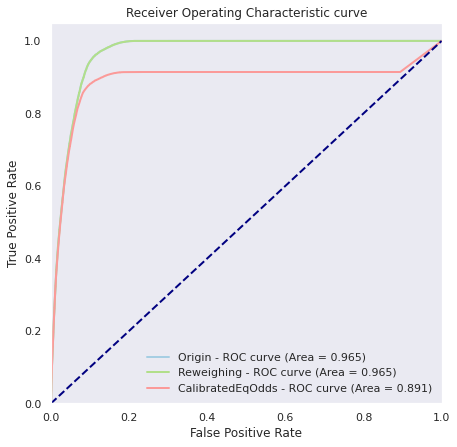

In [64]:
plot_compare_model_performance(metrics_df, test_data)

<img src = https://i.pinimg.com/736x/32/4b/f9/324bf9f369fef8385d30d9e645ae1f33.jpg width = 400/>

**Fairness Score**: We can say that, our data is not biased when we consider various metrics across all the pre/in/post processing algorithms. The `Origin` model (in our case this was our RandomForestClassifier with best Hyperparameters) shows a fairness score which is only slightly less than the `Reweighing` bias pre-processing and same as the `Calibarated Equality of Odds` bias post-processing.

**Accuracy**: Because there was no bias to begin with, our best accuracy stays at 92% after the `Reweighing` preprocessing bias. The accuracy has dipped for the `Calibrated Equality Odds` postprocessing method, however, as we say, it has the same fairness score as out `Origin` model and hence, we will choose the latter.

**We move on to our third and [final notebook](https://colab.research.google.com/drive/1A1qq1yEfcZ3cIVE8eiBX80Jxu3YXExo6?authuser=2#scrollTo=feZ5-znQmzyH) of Interpretability where we explore and understand various methods of understanding and making sense of the predictions**